In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from darksky import forecast
from datetime import datetime as dt
import datetime

from modules.nypd_data import load_clean_felonies
from modules.nyc_shapefiles import read_nyc_shapefiles
from modules.weather import get_precinct_centroids
from modules.weather import get_mean_latlon
from modules.weather import write_weather_data
from modules.weather import read_weather_data
from modules.weather import read_api_key


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Before running: execute "tar -xvf weather_hist.tar.gz"
# from the root directory of the git repo
#
# To make the files from scratch (not necessary):
#
#nypd_data = load_clean_felonies()
#precinct_dict, tract_dict, merged_census_info = read_nyc_shapefiles()
#centroids = get_precinct_centroids(precinct_dict)
#nyc_mean_latlon = get_mean_latlon(centroids)
#nypd_dates = nypd_data['COMPLAINT_DATETIME'].dt.date.unique()
#hours = range(2,26,4)
#darksky_api_key = read_api_key()

/Users/jsamet/anaconda2/envs/py3k/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
#new_nypd_dates = []
#one_day = datetime.timedelta(days=1)
#cur_day = nypd_dates[-1] + one_day
#while cur_day.month < 12:
#    new_nypd_dates.append(cur_day)
#    cur_day += one_day

In [20]:
#write_weather_data(new_nypd_dates, hours, darksky_api_key, nyc_mean_latlon, append_output=True)

In [21]:
# 

weather_hist = read_weather_data()
weather_hist

,apparentTemperature,cloudCover,dewPoint,humidity,icon,nearestStormBearing,nearestStormDistance,ozone,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
Local_Datetime,,,,,,,,,,,,,,,,,,,,
2006-01-02 02:00:00-05:00,34.61,0.24,31.26,0.78,clear-night,NaN,NaN,NaN,0.0000,0.00,NaN,1023.60,Clear,37.62,1136185200,0.0,9.35,243.0,NaN,3.96
2006-01-02 06:00:00-05:00,35.32,0.84,32.01,0.77,partly-cloudy-night,NaN,NaN,NaN,0.0000,0.00,NaN,1023.18,Mostly Cloudy,38.55,1136199600,0.0,9.52,220.0,NaN,4.35
2006-01-02 10:00:00-05:00,39.27,0.43,33.17,0.72,partly-cloudy-day,NaN,NaN,NaN,0.0000,0.00,NaN,1024.20,Partly Cloudy,41.55,1136214000,1.0,9.38,184.0,NaN,3.82
2006-01-02 14:00:00-05:00,42.95,0.63,31.98,0.61,partly-cloudy-day,NaN,NaN,NaN,0.0000,0.00,NaN,1021.33,Mostly Cloudy,44.41,1136228400,1.0,9.74,153.0,NaN,3.40
2006-01-02 18:00:00-05:00,35.07,1.00,36.84,0.87,rain,NaN,NaN,NaN,0.0737,1.00,rain,1020.90,Rain,40.52,1136242800,0.0,4.60,96.0,NaN,8.29
2006-01-02 22:00:00-05:00,32.50,1.00,37.54,0.92,rain,NaN,NaN,NaN,0.0512,1.00,rain,1016.11,Light Rain,39.62,1136257200,0.0,5.30,67.0,NaN,11.65
2006-01-03 02:00:00-05:00,31.03,1.00,38.17,0.92,rain,NaN,NaN,NaN,0.1284,1.00,rain,1011.36,Rain and Breezy,40.33,1136271600,0.0,3.60,64.0,NaN,19.50
2006-01-03 06:00:00-05:00,27.68,1.00,35.08,0.92,rain,NaN,NaN,NaN,0.0509,1.00,rain,1010.34,Light Rain,37.25,1136286000,0.0,4.38,47.0,NaN,17.06
2006-01-03 10:00:00-05:00,27.15,1.00,34.24,0.91,rain,NaN,NaN,NaN,0.0297,0.96,rain,1011.98,Light Rain,36.68,1136300400,1.0,2.93,46.0,NaN,16.37


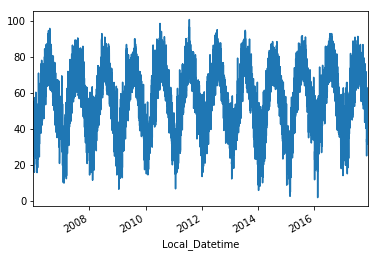

In [22]:
weather_hist['temperature'].plot()
plt.show()


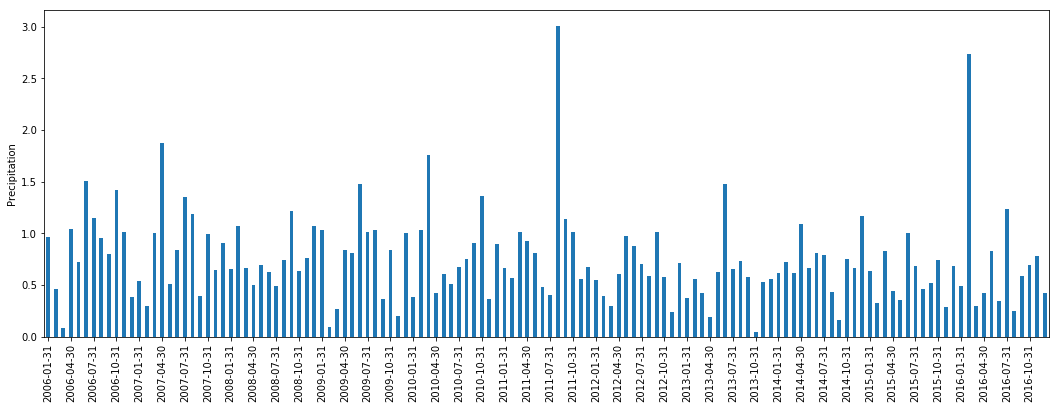

In [4]:
monthly_precipitation = weather_hist['precipIntensity'].resample('M').sum()
monthly_precipitation = pd.Series(monthly_precipitation.values, monthly_precipitation.index.date)
monthly_precipitation.plot(kind='bar', figsize=(18,6))
ax = plt.gca()
start, end = ax.get_xlim()
new_labels = [l for l in ax.get_xticklabels()][::3]
ax.set_xticklabels(new_labels)
ax.set_xticks(0.5+np.arange(start, end, (end-start)/len(new_labels)))
ax.set_ylabel('Precipitation')
plt.show()

In [5]:
# Below this cell isn't particularly relevant to this project.
# I included it because I've been learning about the Fourier transform
# and wanted to see it in action.
#
# It correctly figures out that the biggest repeating patterns in the temperature
# are 1 year long and 1 day long, respectively.
# 
# Math!

In [6]:
temperature_fft = np.fft.rfft(weather_hist['temperature'])
biggest_components = np.argsort(-np.absolute(temperature_fft))[1:3]
print(biggest_components)

[  11 4017]


In [7]:
time_interval = weather_hist.index[-1] - weather_hist.index[0] + pd.Timedelta(4, 'h')
days = (time_interval/biggest_components).astype('timedelta64[D]').astype(np.int32)
hours = (time_interval/biggest_components).astype('timedelta64[h]').astype(np.int32)%24
for row in np.array([days, hours]).T:
    print('%dd %dh' % tuple(row))

365d 4h
1d 0h
